<a href="https://colab.research.google.com/github/ateffal/omdena-projects/blob/main/HOT/data_augmentation_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data augmentation pipeline

The purpose of this notebook is to create a pipeline for augmenting the images found in the data folder of the official folder of OMEDENA HOT projet : [Data](https://drive.google.com/drive/folders/1jK4ua8xNxsEB4ArK6GbmsnPoEj3KBrJU?usp=drive_link
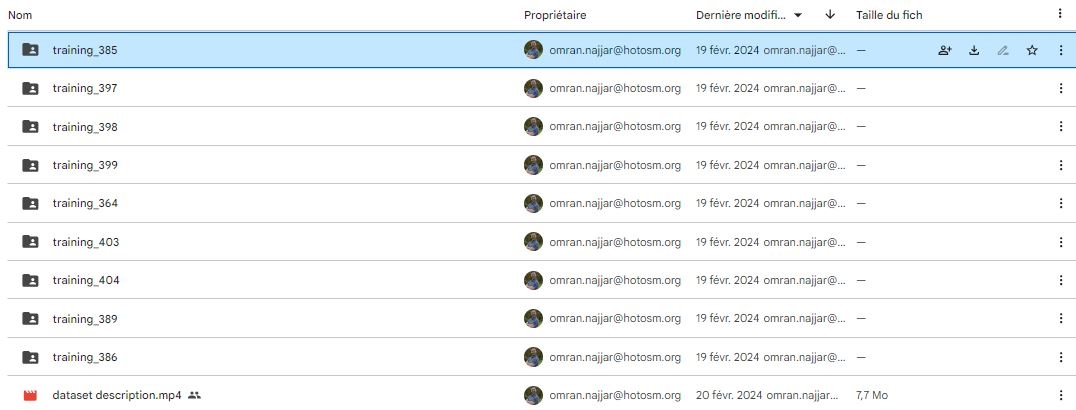

Each traing folder contains a single preprocessed folder that contains the following folders :
- chips
- binarymasks
- labels


for more a detailled description take a look at this [video](https://drive.google.com/file/d/1q9l3xGJVe9RPdph75irzMIlXS_IJXMN6/view?usp=sharing).


We will maily rely on [Albumentation](https://albumentations.ai/)

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from skimage import io
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
# which traing folder to use
training_n = "training_364"  # change this if you want test with other images

In [3]:
images_path = "/content/drive/MyDrive/HOT-Official Folder/Data/Omdena AI challenge datasets 02-2024/" + training_n + "/preprocessed/"

In [4]:
# create three list that contains the names of files in the folders : binarymasks, chips and labels
binarymasks = os.listdir(images_path+'binarymasks/')
chips = os.listdir(images_path+'chips/')
labels = os.listdir(images_path+'labels/')

print("lenth of chips : ", len(chips))
print("lenth of masks : ", len(binarymasks))
print("lenth of labels : ", len(labels))

lenth of chips :  401
lenth of masks :  401
lenth of labels :  399


In [5]:
# some images
chips[10:15]

['OAM-1251453-1026614-21.tif',
 'OAM-625724-513307-20.tif',
 'OAM-1251449-1026607-21.tif',
 'OAM-1251449-1026609-21.tif',
 'OAM-1251461-1026610-21.tif']

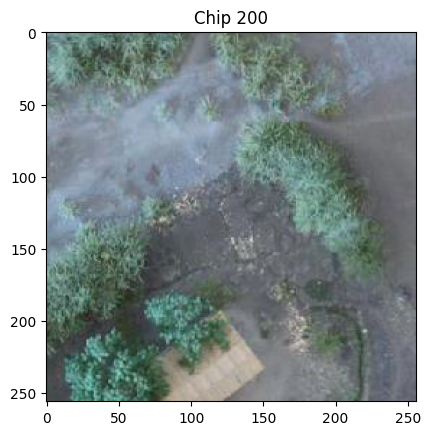

In [6]:
# Read the 200th image
image = cv2.imread(images_path +'chips/' + chips[200], cv2.IMREAD_UNCHANGED)

# Plot the image using matplotlib
plt.imshow(image, cmap='gray')
plt.title('Chip 200')
plt.show()

# Installation of Albumentations

In [7]:
!pip install -U -q albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.7/155.7 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/313.5 kB 22.2 MB/s eta 0:00:00


In [8]:
import albumentations as A

We will read the same 200th image in chips

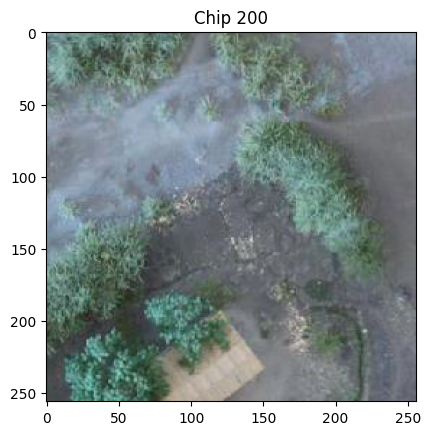

In [9]:
# Read the 200th image
image = cv2.imread(images_path +'chips/' + chips[200], cv2.IMREAD_UNCHANGED)

# Plot the image using matplotlib
plt.imshow(image, cmap='gray')
plt.title('Chip 200')
plt.show()

Define the Compose class that will perform augmentation. The first parameter is the list of transformations

In [10]:
transform = A.Compose([
    A.RandomCrop(width=256, height=256),
    A.HorizontalFlip(p=1.0),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomShadow(),
    A.GaussianBlur(),
    A.RandomBrightnessContrast(brightness_limit=1, contrast_limit=1, p=1.0)
])

These are the first 10 transformations from [this doc page](https://github.com/albumentations-team/albumentations?tab=readme-ov-file#pixel-level-transforms) :

- AdvancedBlur
- Blur
- CLAHE
- ChannelDropout
- ChannelShuffle
- ChromaticAberration
- ColorJitter
- Defocus
- Downscale
- Emboss
- Equalize, FDA,FancyPCA, FromFloat, GaussNoise,...*texte en italique*

In [11]:
transformed_image = transform(image=image)

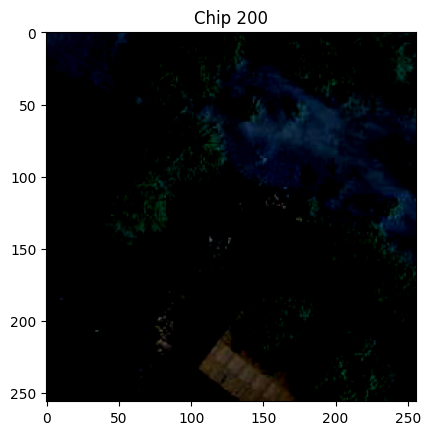

In [12]:
# Plot the image using matplotlib
plt.imshow(transformed_image['image'], cmap='gray')
plt.title('Chip 200')
plt.show()

#### After these experimentations, do not forget that both images and there masks need the ***same transformations***

# Image and mask augmentation using Albumentations

Here are the steps needed :
1.   You import the required libraries.
2.   You define an augmentation pipeline.
3.   You read images and masks from the disk.
4.   You pass an image and one or more masks to the augmentation pipeline and receive augmented images and masks.

[For more details read here](albumentations.ai/docs/getting_started/mask_augmentation/))

The first step is already done above.

Step two. Don't forget that we stored the names of chips, binarymasks and labels :

In [13]:
# first 5 chips
chips[:5]

['OAM-625731-513302-20.tif',
 'OAM-312865-256652-19.tif',
 'OAM-625723-513302-20.tif',
 'OAM-1251435-1026599-21.tif',
 'OAM-1251446-1026613-21.tif']

In [14]:
binarymasks[0:5]

['OAM-1251449-1026605-21.mask.tif',
 'OAM-625731-513302-20.mask.tif',
 'OAM-1251439-1026599-21.mask.tif',
 'OAM-1251463-1026605-21.mask.tif',
 'OAM-1251461-1026610-21.mask.tif']

In [15]:
# Do the have the same length ? meaning : for each image we one and only one mask ?
len(chips) == len(binarymasks)

True

In [16]:
# create a dic that contain for each chip (key), the corresponding labels and masks
chips_dic = {}

for chip in chips:
  chips_dic[chip] = {'binarymasks' : [m for m in binarymasks if m.startswith(chip[:-4])],
                       'labels' : [l for l in labels if l.startswith(chip[:-4])]}

In [17]:
# the mask and the labels for a given image
image_index = 10
img = chips[image_index]
chips_dic[img]

{'binarymasks': ['OAM-1251453-1026614-21.mask.tif'],
 'labels': ['OAM-1251453-1026614-21.geojson']}

In [18]:
# read an image
image = cv2.imread(images_path + '/chips/' + img)

array([[[102, 106, 117],
        [102, 106, 117],
        [101, 105, 116],
        ...,
        [118, 119, 117],
        [124, 125, 123],
        [122, 123, 121]],

       [[104, 108, 119],
        [103, 107, 118],
        [101, 105, 116],
        ...,
        [116, 119, 117],
        [116, 117, 115],
        [129, 130, 128]],

       [[107, 111, 122],
        [105, 109, 120],
        [103, 107, 118],
        ...,
        [131, 133, 133],
        [115, 117, 117],
        [117, 119, 119]],

       ...,

       [[ 63,  61,  61],
        [ 76,  74,  74],
        [ 83,  78,  79],
        ...,
        [224, 208, 191],
        [222, 207, 188],
        [220, 205, 186]],

       [[ 65,  60,  61],
        [ 65,  60,  61],
        [ 87,  83,  82],
        ...,
        [223, 208, 189],
        [223, 206, 187],
        [222, 205, 186]],

       [[ 67,  62,  63],
        [ 58,  54,  53],
        [101,  96,  95],
        ...,
        [225, 208, 189],
        [223, 206, 187],
        [223, 206, 185]]], dtype=uint8)
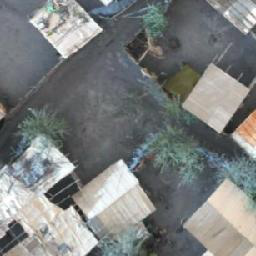

In [29]:
image

In [20]:
# read the corresponding mask
image_mask = cv2.imread(images_path + '/binarymasks/' + chips_dic[img]['binarymasks'][0], cv2.IMREAD_UNCHANGED)

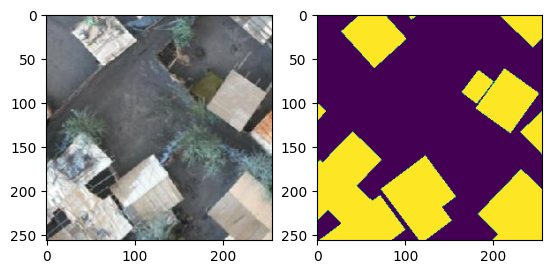

In [21]:
# Create a figure
fig, ax = plt.subplots(1,2)

# Plot the image
ax[0].imshow(image)
#¨plot the mask
ax[1].imshow(image_mask)


We will use a simple rotation :

In [22]:
transform = A.Compose([
    A.RandomRotate90(p=1)
])

transform

Compose([
  RandomRotate90(always_apply=False, p=1.0),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)

In [23]:
transformed = transform(image=image, mask=image_mask)
transformed_image = transformed['image']
transformed_mask = transformed['mask']

Plot the result :

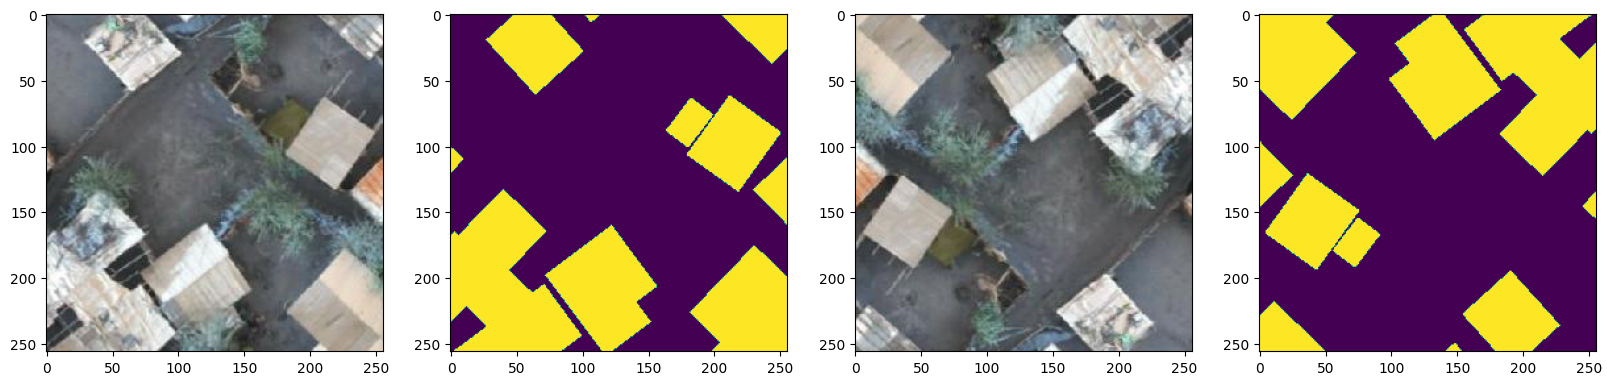

In [24]:
# Create a figure
fig, ax = plt.subplots(1,4, figsize=(20, 10))
# Plot the image
ax[0].imshow(image)
#¨plot the mask
ax[1].imshow(image_mask)
#plot augmented image
ax[2].imshow(transformed_image)
#plot augmented mask
ax[3].imshow(transformed_mask)


What about RandomGamma for example ? What will happen to the mask ?

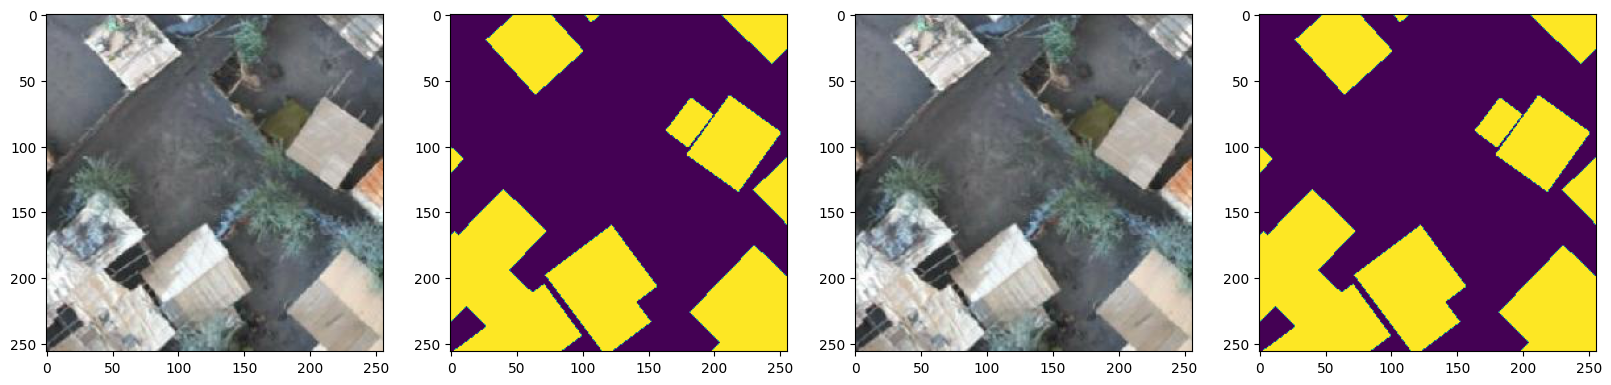

In [25]:
transform = A.Compose([
    A.RandomGamma(p=1)
])


transformed = transform(image=image, mask=image_mask)
transformed_image = transformed['image']
transformed_mask = transformed['mask']



# Create a figure
fig, ax = plt.subplots(1,4, figsize=(20, 10))
# Plot the image
ax[0].imshow(image)
#¨plot the mask
ax[1].imshow(image_mask)
#plot augmented image
ax[2].imshow(transformed_image)
#plot augmented mask
ax[3].imshow(transformed_mask)



Next steps :
- Create a function that augment an image given its path file and the needed transformations (dic with key as type a transformation and values is a list of dics : param : value)
- use this fucntion to iterate over all the images

### Now let's make this cleaner by creating a function

In [34]:
def augmente_image(images_path_, img_, augmentations = [A.RandomRotate90(p=1)], output_path = '/content/drive/MyDrive/HOT_output/'):

  # read the image
  image = cv2.imread(images_path_ + '/chips/' + img_)

  # read the corresponding mask
  image_mask = cv2.imread(images_path_ + '/binarymasks/' + chips_dic[img_]['binarymasks'][0], cv2.IMREAD_UNCHANGED)

  # Create a figure
  fig, ax = plt.subplots(1,2)

  # Plot the image
  ax[0].imshow(image)
  #¨plot the mask
  ax[1].imshow(image_mask)




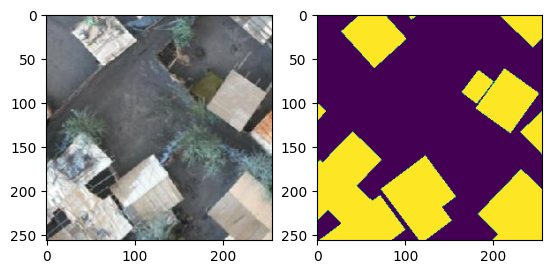

In [35]:
augmente_image(images_path, img)

In progress...

Next  :
- add augmentation code
- store the augmented image and augmented mask in the output_path